In [1]:
!pip install torch
!pip uninstall PIL
!pip install --upgrade --force-reinstall pillow

  Using cached Pillow-8.0.1-cp38-cp38-macosx_10_10_x86_64.whl (2.2 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.0.1
    Uninstalling Pillow-8.0.1:
      Successfully uninstalled Pillow-8.0.1


In [2]:
!pip install torchvision

Imports


In [2]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import torch
print(torch.__version__)

1.7.0


Set Up display

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

Deep Q-Network

In [24]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        #fc - fully connected layer 
        self.fc1 = nn.Linear(in_features = img_height*img_width*3, out_features = 24) 
        #3 corresponds to 3 colors in rgb images that will be received by the layer as inputs
        self.fc2 = nn.Linear(in_features = 24, out_features = 32)
        self.out = nn.Linear(in_features = 32, out_features = 2) #since only 2 outputs are possible, 
        # either the cart can move right /left so # output = 2
        

        
    def forward(self,t): #t= image tensor
        t = t.flatten(start_dim = 1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t
    
#n/w will be outputting Qvalues that correspond to actions that agent can take
#in the given state

Experience Class

In [25]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))
#namedtuple is a python function for calling tuples with named fields 

In [7]:
e = Experience(2,3,1,4)

In [8]:
e

Experience(state=2, action=3, next_state=1, reward=4)

Replay Memory

In [27]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity #initalize capacity to whatever capacity has been passed
        self.memory = [] #initliaze memory to empty - this will hold stored experiences
        self.push_count = 0 #keeps track of how many experiences we have added to memory
        
    def push(self, experience):
        if len(self.memory) < self.capacity: #checking if the amount of experiences we have in memory < memory's capacity
            self.memory.append(experience)
        else :
            self.memory[self.push_count % self.capacity] = experience #if new experience > capacity : we overwrite the oldest experiences
        self.push_count += 1
        
    def sample(self, batch_size): #sample experiences from replay memory to train DQN
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size): #whether or not we can sample from memory
        return len(self.memory) >= batch_size
        

to get a balance between Exploration and Exploitation, using a strategy called Epsilon Greedy 
with epsilon = 1 --- the agent will learn by exploring

with decay rate, the agent will start exploring less and less and exploiting more 


with epsilon = 0 --- the agent will learn by exploiting

In [10]:
class EplisonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)
        

Reinforcement Learning Agent

In [11]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0 #agent's current step number in the environment
        self.strategy = strategy
        self.num_actions = num_actions #number of possible actions that an agent can take in a given state ie 2 
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action =  random.randrange(self.num_actions)
            return torch.tensor([action]).to(device) #explore
        
        else : 
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device) #exploit
        

Environment Manager

In [12]:
class CartPoleEnvManager():
    def __init__(self,device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode = 'human'):
        return self.env.render(mode)
   
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _,reward, self.done, _ = self.env.step(action.item()) #returns tuple (st,a,st+1,done)
        return torch.tensor([reward], device = self.device)
    
    def just_starting(self):
        return self.current_screen is None #if current screen is none it means we are at the initial state and 
    #havent rendered anything yet 
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else :
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1)) #pytorch experience
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
         
        
        #strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        #convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype = np.float32) / 255
        screen = torch.from_numpy(screen)
        
        #use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) #add a batch dimenstion 
        
        
        
        

Example of Non processed screen

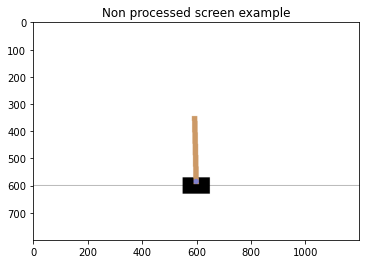

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non processed screen example')
plt.show()

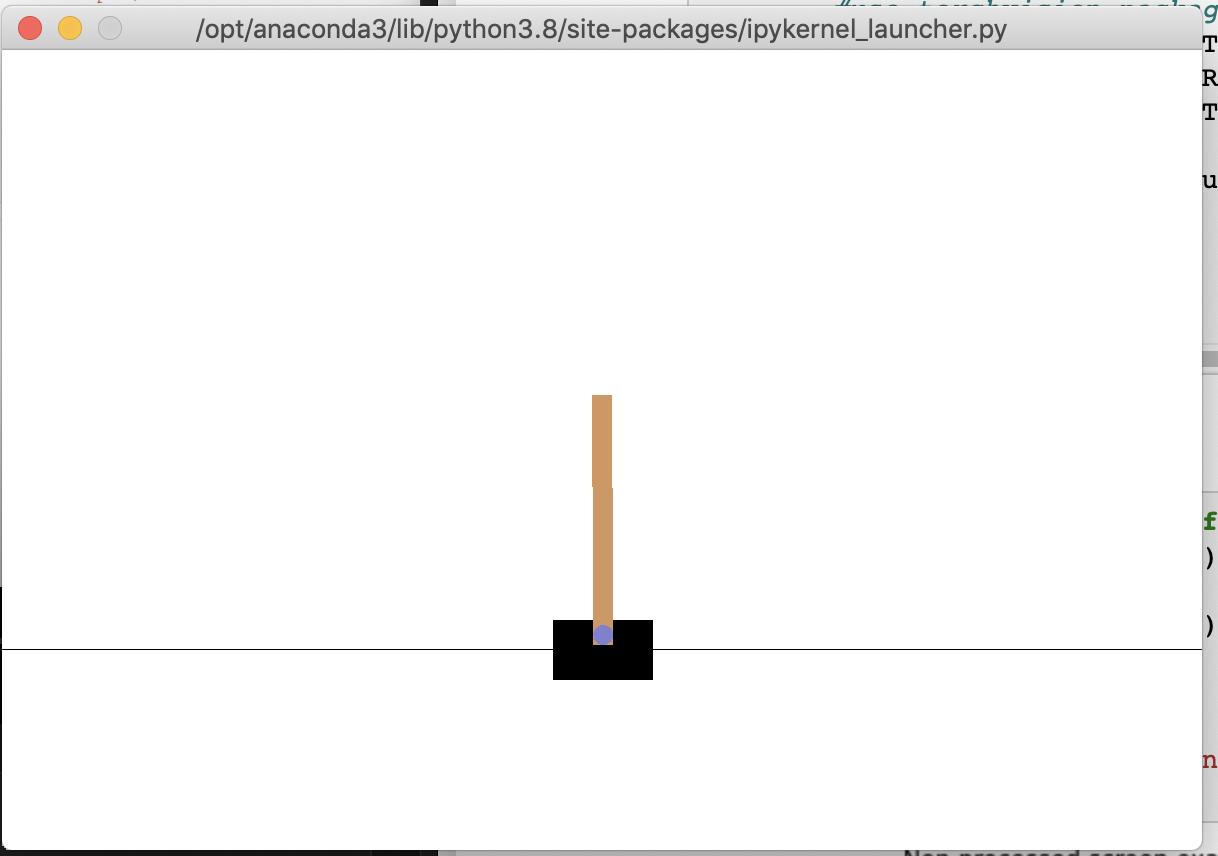

Example of processed screen 

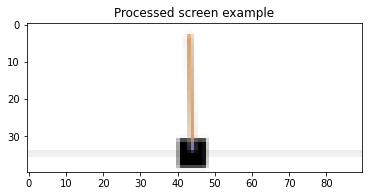

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = 'none')
plt.title('Processed screen example')
plt.show()

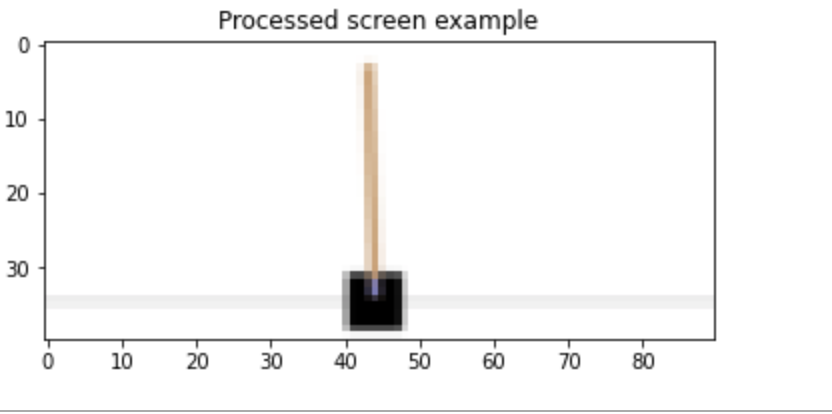

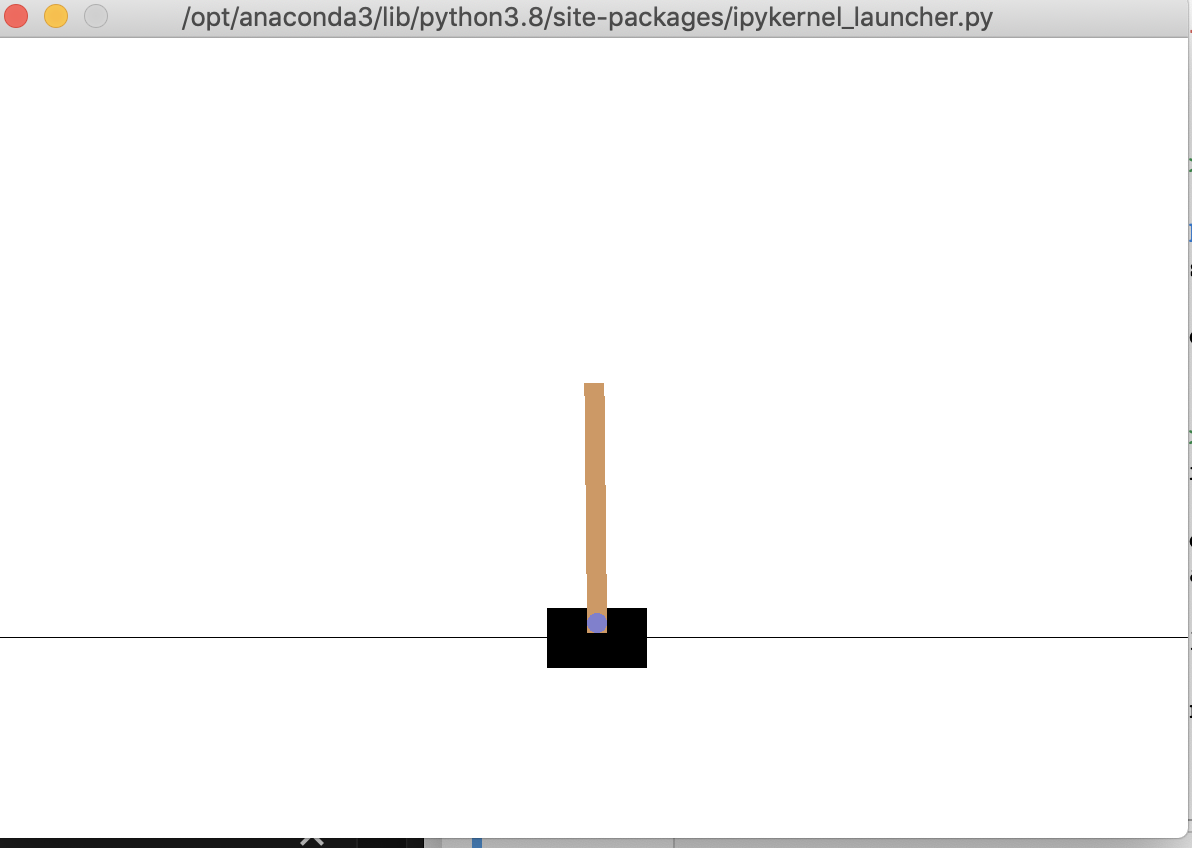

Example of starting state

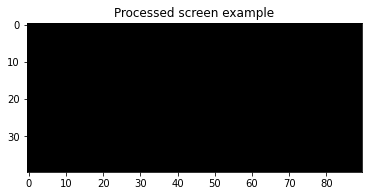

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = 'none')
plt.title('Processed screen example')
plt.show()

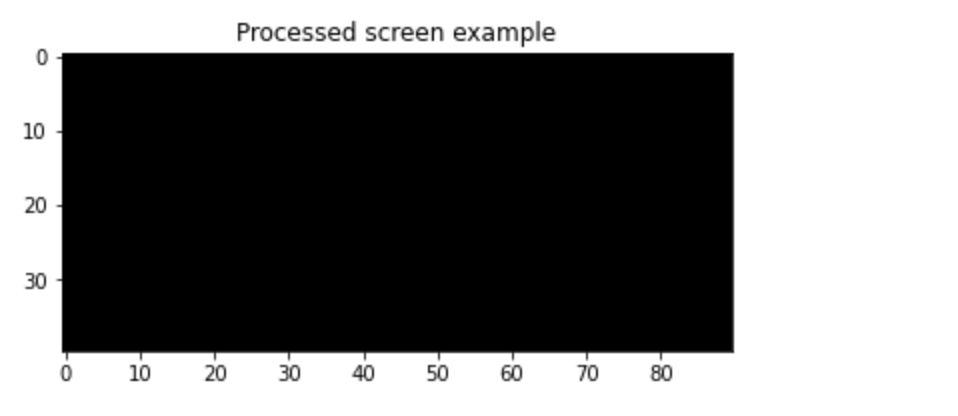

Example of Non-Starting State

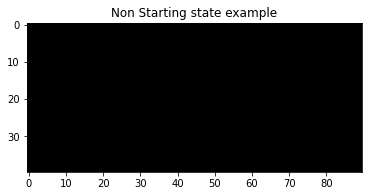

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation= 'none')
plt.title('Non Starting state example')
plt.show()

In [13]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    if is_ipython : display.clear_output(wait = True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype= torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension =0, size = period, step = 1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    
    else :
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

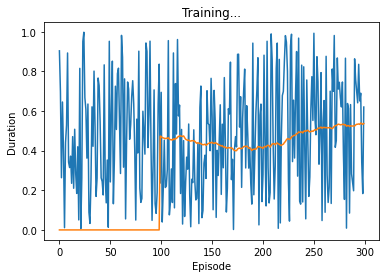

In [14]:
plot(np.random.rand(300), 100)

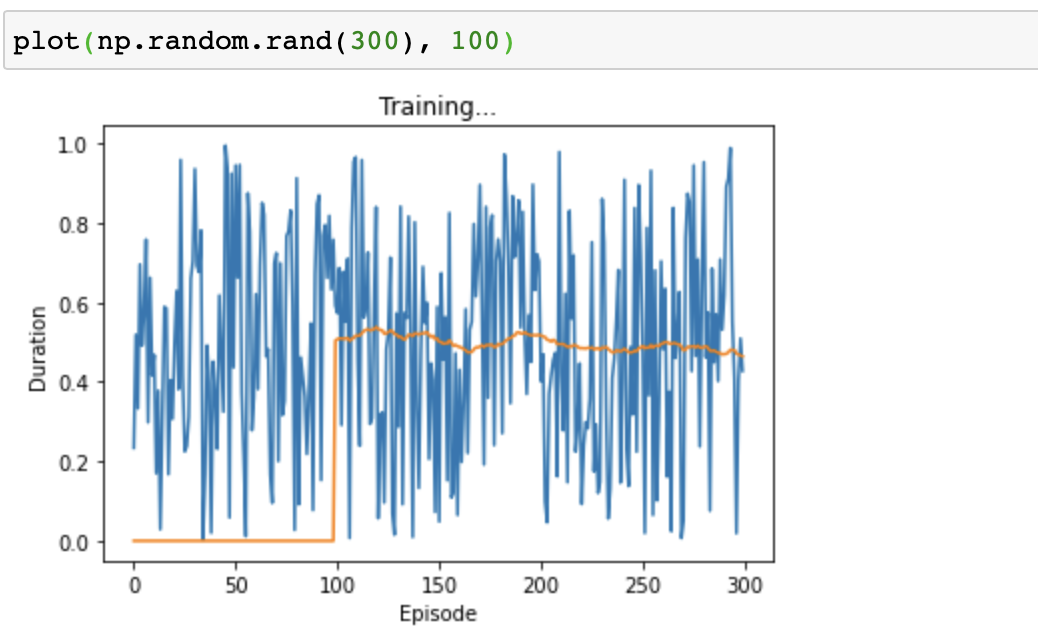

Tensor processing

In [15]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1= torch.cat(batch.state)
    t2= torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1,t2,t3,t4)

In [16]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values
    

Main Program

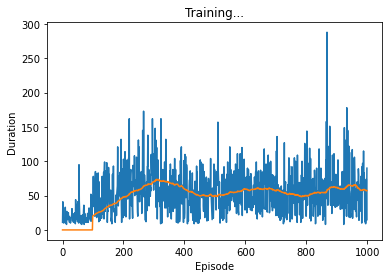

Episode 1000 
 100 episode moving avg: 57.38


In [19]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 10000
lr = 0.01
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available () else "cpu")
em = CartPoleEnvManager(device)
strategy = EplisonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params = policy_net.parameters(), lr = lr)

episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0 :
        target_net.load_state_dict(policy_net.state_dict())

em.close()

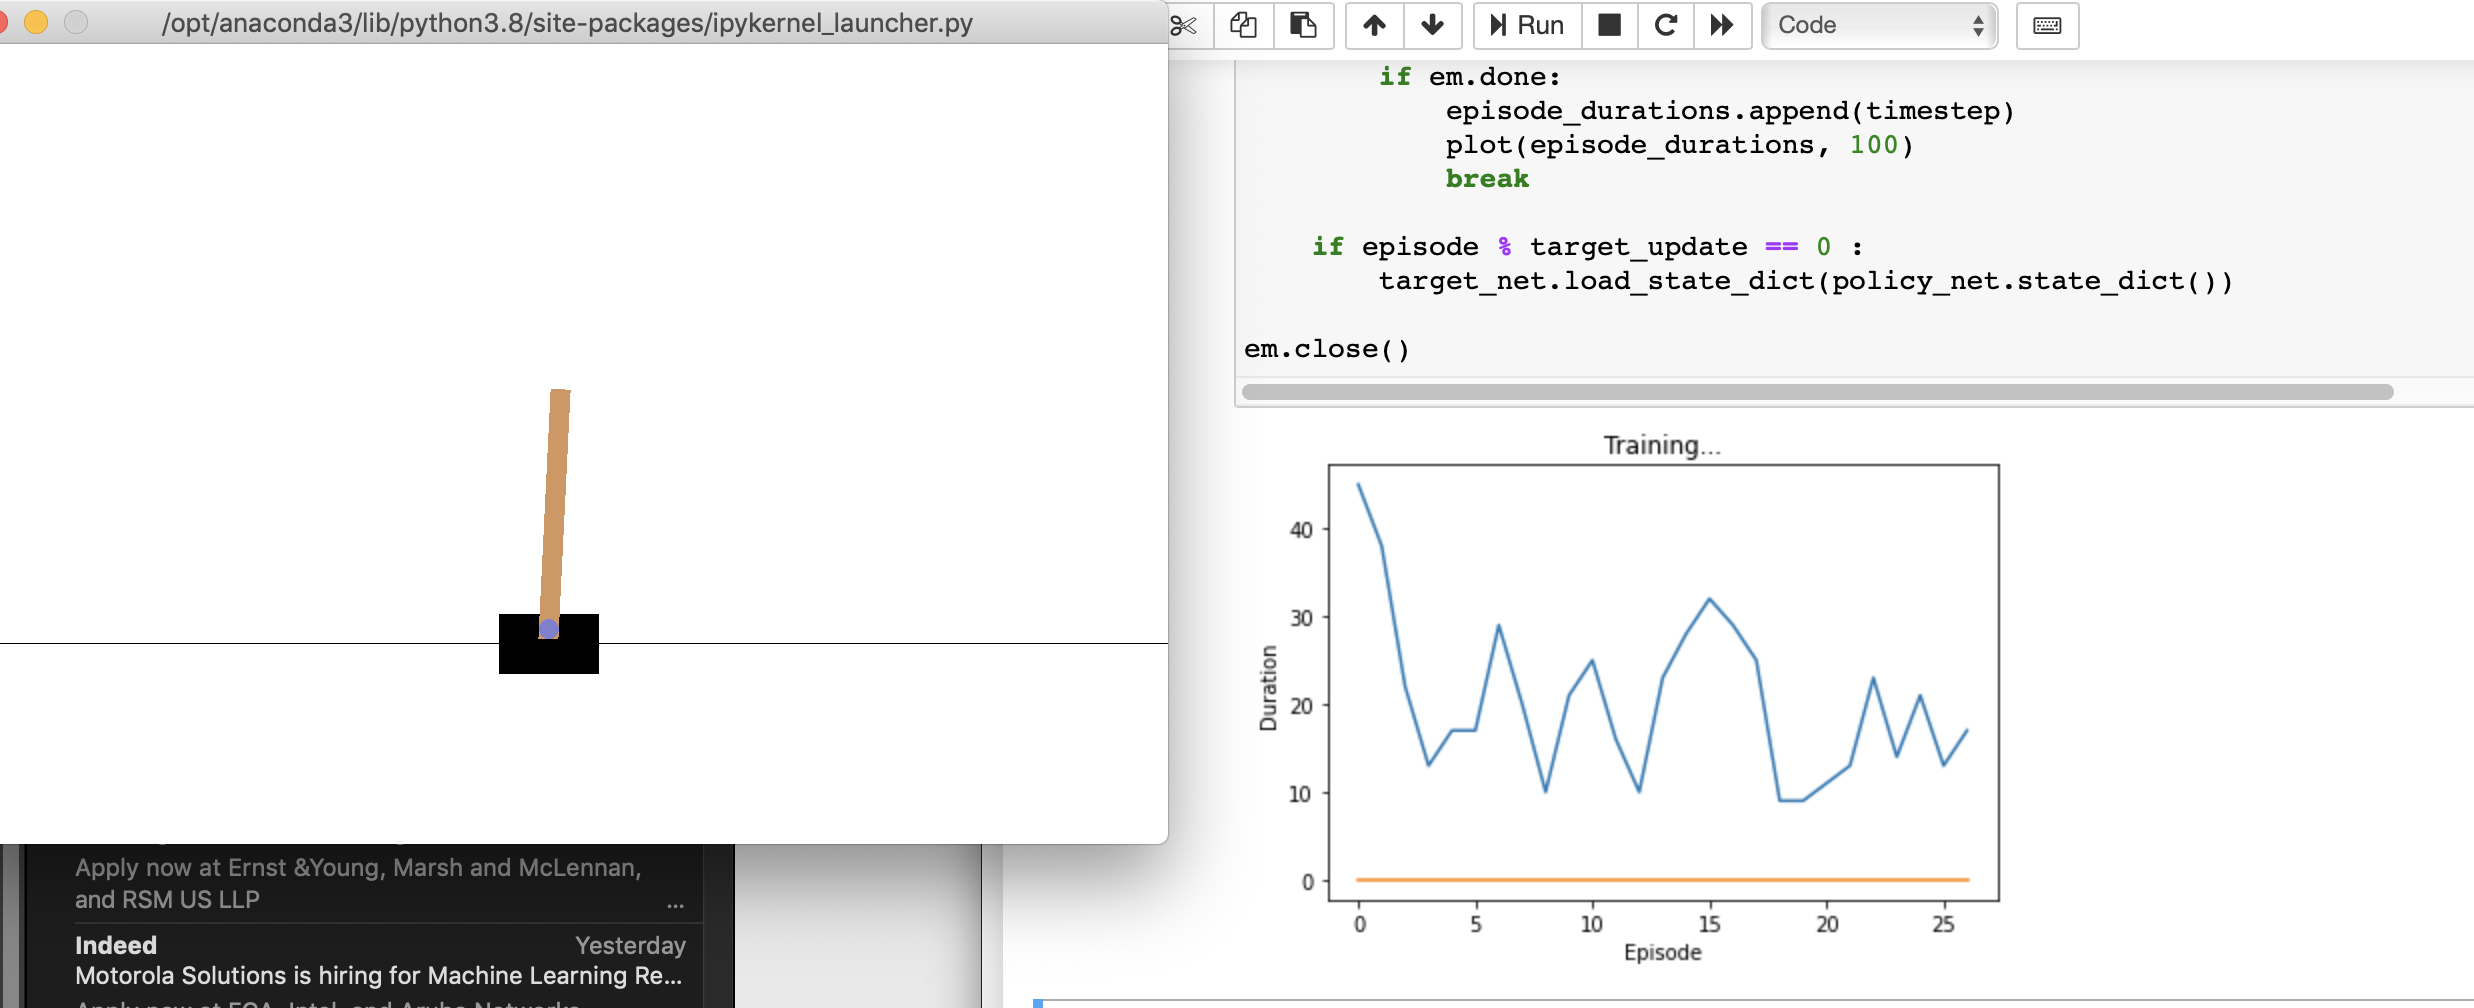

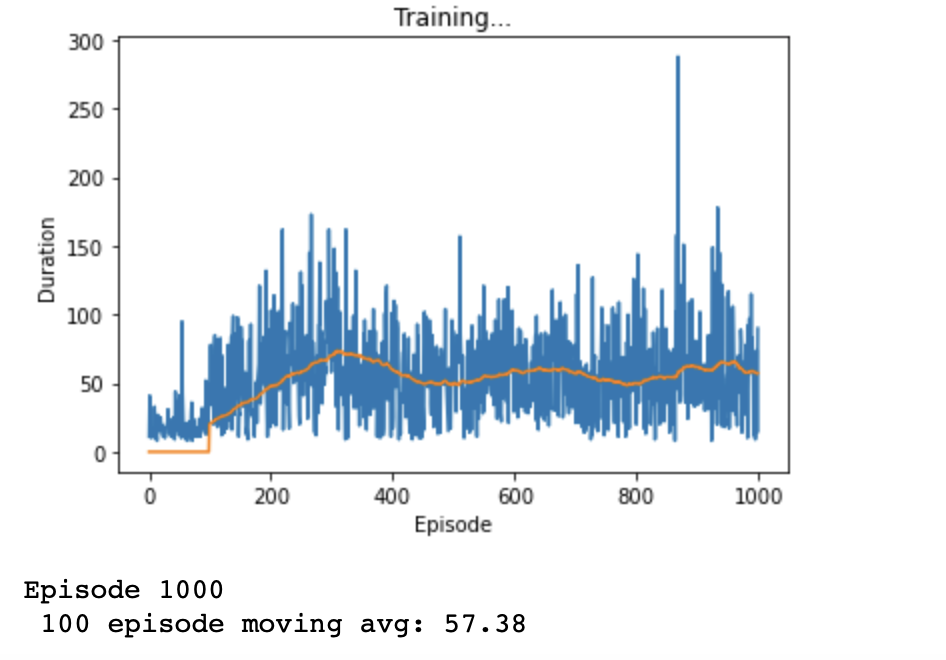

In [18]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

DQN overcomes unstable learning by mainly 4 techniques.

Experience Replay

Target Network

Clipping Rewards

Skipping Frames

References:


https://www.youtube.com/watch?v=FU-sNVew9ZA&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=15


https://www.youtube.com/watch?v=FU-sNVew9ZA&list=PLZbbT5o_s2xoWNVdDudn51XM8lOuZ_Njv&index=15

Copyright <YEAR> <COPYRIGHT HOLDER>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.